In [2]:
%load_ext autoreload
%autoreload 2
from corr_study.datasetApi import *
from corr_study.correlation import *
from corr_study.voxels import *
from corr_study.mobileclassifier import *
from matplotlib import pyplot as plt

dataset = Dataset("corr_study/dataset/")

route = dataset.get_routes_TLC()[0]
ids = dataset.get_ids_CV(Town.T1, Weather.Clear, Time.Sunset, Sensor.LFL)

route = dataset.get_routes_TLC()[0]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2023-03-16 11:44:42.739063: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
train, val, test, len_train, len_val, len_test = create_tf_dataset(dataset, [["t3high", Weather.Clear, Time.Sunset, Sensor.LT],
                                                                             ["t3medium", Weather.Clear, Time.Sunset, Sensor.LT],
                                                                             ["t3low", Weather.Clear, Time.Sunset, Sensor.LT],], 8)
from matplotlib import pyplot as plt
i=0
for x, y in train:
    if i > 2:
        break
    print(np.min(x[0,:,:,1]), np.max(x[0,:,:,1]))
    plt.imshow(x[0,:,:,0])
    plt.show()
    plt.imshow(x[0,:,:,1])
    plt.show()
    plt.imshow(y[0,:,:,0])
    plt.show()
    i+=1

# LiteUNet

In [2]:
train, val, test, len_train, len_val, len_test = create_tf_dataset(dataset, [["t3high", Weather.Clear, Time.Sunset, Sensor.LT],
                                                                             ["t3medium", Weather.Clear, Time.Sunset, Sensor.LT],
                                                                             ["t3low", Weather.Clear, Time.Sunset, Sensor.LT],], 4)
m = get_model((1024,1024,2))
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
m.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.BinaryAccuracy()], run_eagerly = True)

2023-03-15 12:27:30.053702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 12:27:30.054587: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping("val_loss", patience=3, restore_best_weights=True),
             tf.keras.callbacks.ModelCheckpoint("network.h5", monitor="val_loss", save_best_only=True)]

history = m.fit(train, steps_per_epoch=int(np.ceil(len_train/4)), epochs=10, validation_data=val, validation_steps=int(np.ceil(len_val/4)), callbacks=callbacks)

In [25]:
s = train.take(1)

1/1 [==============================] - 1s 1s/step


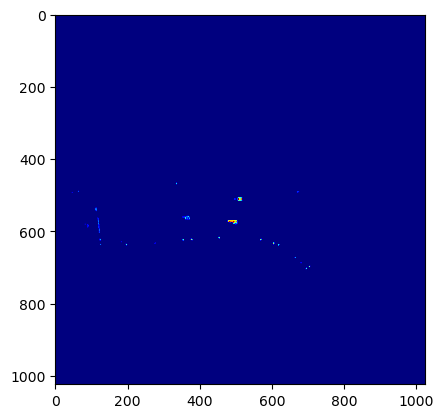

(array([0., 1.]), array([738538, 310038]))


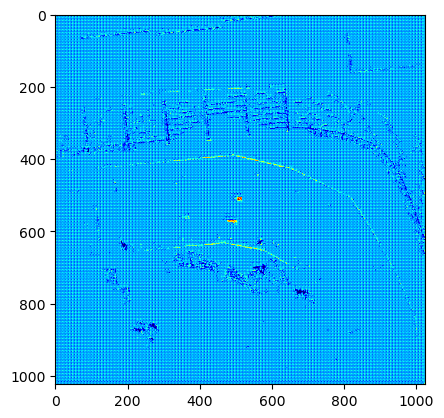

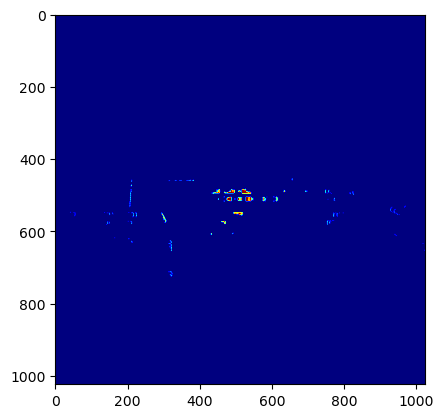

(array([0., 1.]), array([738105, 310471]))


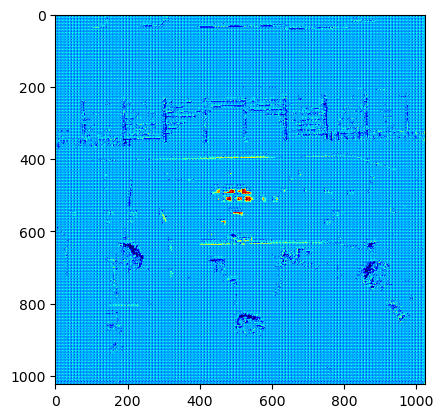

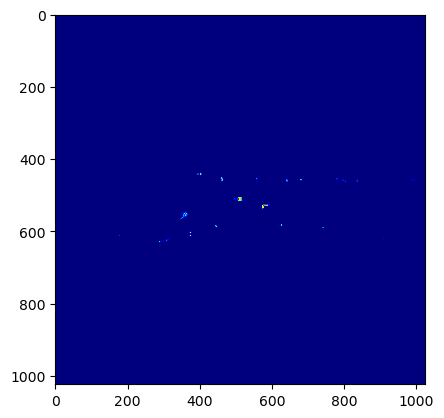

(array([0., 1.]), array([738489, 310087]))


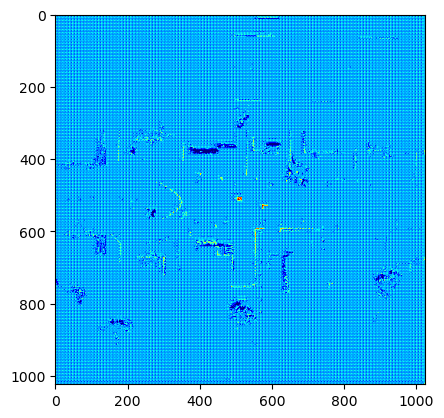

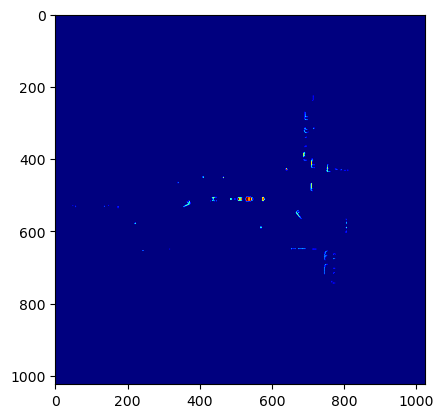

(array([0., 1.]), array([739069, 309507]))


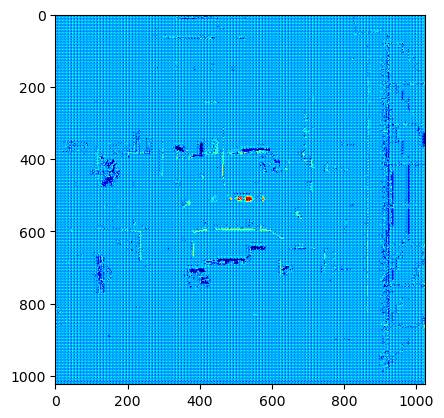

In [28]:
for x, y in s:
    pred = m.predict(x)
    pred = pred>.5
    pred = pred.astype(float)
    for i in range(4):
        # plt.imshow(x[i,:,:,0], vmin=0, vmax=1, cmap='jet')
        # plt.show()
        # plt.imshow(x[i,:,:,1], vmin=0, vmax=1, cmap='jet')
        # plt.show()
        plt.imshow(y[i,:,:,0], vmin=0, vmax=1, cmap='jet')
        plt.show()
        plt.imshow(pred[i,:,:,0], vmin=0, vmax=1, cmap='jet')
        print(np.unique(pred[i,:,:,0], return_counts=True))
        plt.show()

# MiniUNet

In [ ]:
train, val, test, len_train, len_val, len_test = create_tf_dataset(dataset, [["t3high", Weather.Clear, Time.Sunset, Sensor.LT],
                                                                             ["t3medium", Weather.Clear, Time.Sunset, Sensor.LT],
                                                                             ["t3low", Weather.Clear, Time.Sunset, Sensor.LT],], 4)
m = get_miniUNet((1024,1024,2))
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True,alpha=.9)
m.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.FalseNegatives()], run_eagerly = True)

callbacks = [tf.keras.callbacks.EarlyStopping("val_loss", patience=3, restore_best_weights=True),
             tf.keras.callbacks.ModelCheckpoint("network.h5", monitor="val_loss", save_best_only=True)]

history = m.fit(train, steps_per_epoch=100, epochs=10, validation_data=val, validation_steps=13, callbacks=callbacks)

In [24]:
m = tf.keras.models.load_model('network_miniUNet.h5')
cmap = "Greens" 
s = test.take(1)
for x, y in s:
    pred = m.predict(x)
    pred = pred>.5
    pred = pred.astype(float)
    for i in range(4):
        fig, ax = plt.subplots(1,3,figsize=(30,10))
        ax[0].imshow(x[i,:,:,1])
        ax[1].imshow(y[i,:,:,0], vmin=0, vmax=1, cmap=cmap)
        ax[2].imshow(pred[i,:,:,0], vmin=0, vmax=1, cmap=cmap)
        plt.show()

NameError: name 'test' is not defined

# Non machine-learning

In [2]:
pcd_top = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, 1)
icp_correlation = []
previous_transformation = None
for i in range(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, i)
    correla, previous_transformation = pcd_top.compare_using_voxels(pcd_top_compare, 0.25, mode=selmaPointCloud.ICP_REGISTRATION, crop_street=True, init_transform=previous_transformation)
    icp_correlation.append(correla)

In [4]:
pcd_top = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, 1)
icp_cluster_correlation = []
previous_transformation = None
for i in range(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, i)
    correla, previous_transformation = pcd_top.compare_using_clusters(pcd_top_compare, 50, mode=selmaPointCloud.ICP_REGISTRATION, crop_street=True, init_transform=previous_transformation)
    icp_cluster_correlation.append(correla)

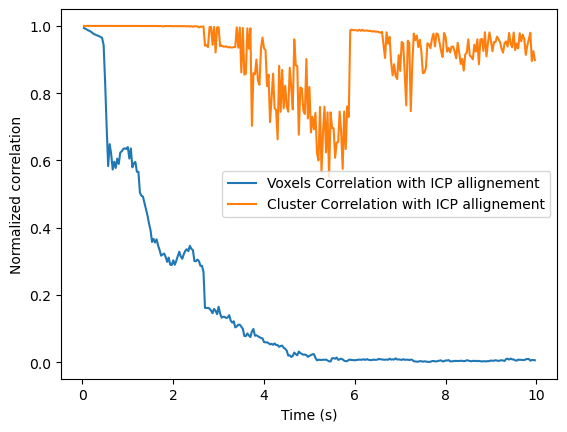

In [5]:
fig, ax = plt.subplots(1,1)
pp, = ax.plot(np.arange(1,300)/30, icp_correlation)
pc, = ax.plot(np.arange(1,300)/30, icp_cluster_correlation)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Normalized correlation")
ax.legend([pp, pc],["Voxels Correlation with ICP allignement", "Cluster Correlation with ICP allignement"])
plt.show()

In [59]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
icp_cluster_mse = []
previous_transformation = None
for i in range(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    correla, previous_transformation = pcd_top.compare_using_clusters(pcd_top_compare, 50, mode=selmaPointCloud.ICP_REGISTRATION, crop_street=True, init_transform=previous_transformation, return_mse=True)
    icp_cluster_mse.append(correla)

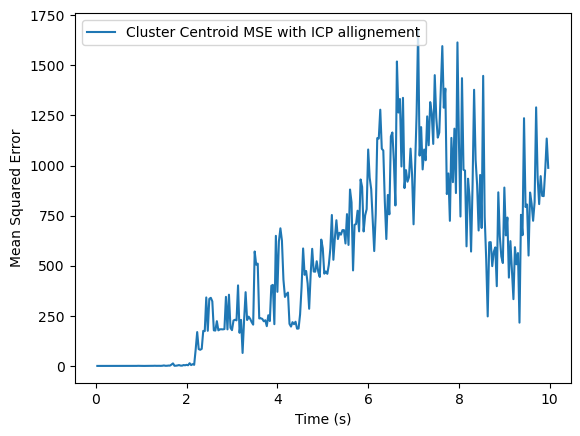

In [60]:
fig, ax = plt.subplots(1,1)
pmse, = ax.plot(np.arange(1,300)/30, icp_cluster_mse)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Mean Squared Error")
ax.legend([pmse],["Cluster Centroid MSE with ICP allignement"])
plt.show()

In [50]:

pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 120)
correla, previous_transformation = pcd_top.compare_using_clusters(pcd_top_compare, 30, mode=selmaPointCloud.ICP_REGISTRATION, crop_street=True, init_transform=None)

In [5]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
center_mass_corr = []
for i in range(1, 101):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    center_mass_corr.append(pcd_top.compare_using_voxels(pcd_top_compare, 0.5))

In [7]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
v_top = pcd_top.voxelize(0.5)
corr = []
for i in range(1, 101):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    corr.append(v_top.compute_correlation(pcd_top_compare.voxelize(0.5, v_top.boundaries)))


In [8]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
v_top = pcd_top.voxelize(0.5)
cross_corr = []
for i in range(1, 101, 1):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    cross_corr.append(v_top.compute_correlation_inferring_offset(pcd_top_compare.voxelize(0.5, v_top.boundaries)))

In [9]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
center_mass_corr_weighted = []
for i in range(1, 101):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    center_mass_corr_weighted.append(pcd_top.compare_using_voxels(pcd_top_compare, 0.5, weighted=True))

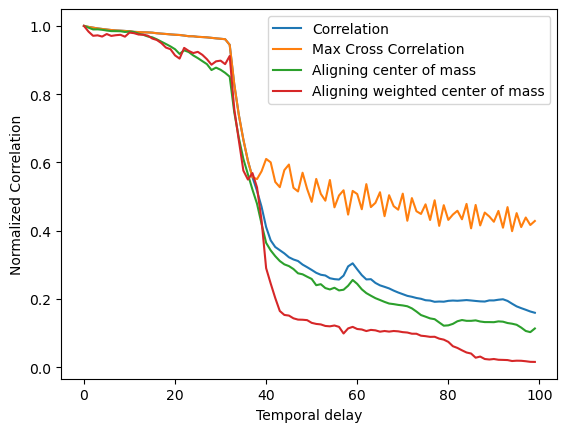

In [10]:
fig, ax = plt.subplots(1,1)
c, = ax.plot(corr)
cc, = ax.plot(cross_corr)
cm, = ax.plot(center_mass_corr)
cmw, = ax.plot(center_mass_corr_weighted)
ax.legend([c, cc, cm, cmw], ["Correlation", "Max Cross Correlation", "Aligning center of mass", "Aligning weighted center of mass"])
plt.ylabel("Normalized Correlation")
plt.xlabel("Temporal delay")
plt.show()

In [30]:
dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 32).visualize()
dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 35).visualize()

In [3]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
mse_mass_center = []
for i in range(1, 101):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    mse_mass_center.append(pcd_top.compare_using_clusters(pcd_top_compare, 10))


In [4]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
mse_mass_center_w = []
for i in range(1, 101):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    mse_mass_center_w.append(pcd_top.compare_using_clusters(pcd_top_compare, 10, weighted=True))


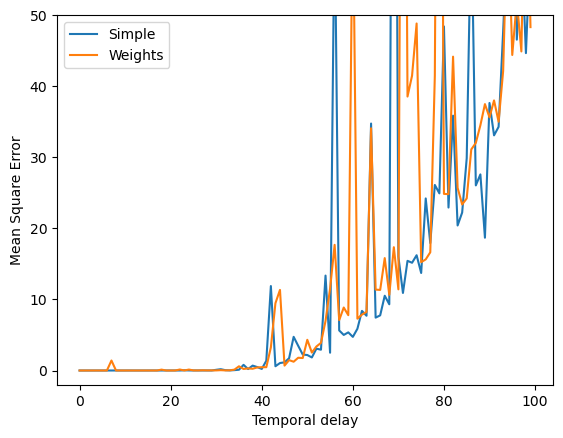

In [5]:
fig, ax = plt.subplots(1,1)
s, = ax.plot(mse_mass_center)
w, = ax.plot(mse_mass_center_w)
ax.legend([s, w], ["Simple", "Weights"])
plt.ylabel("Mean Square Error")
plt.xlabel("Temporal delay")
ax.set_ylim([-2,50])
plt.show()

In [13]:
def compute_oddly_normalized_distance(points):
    dists_matrix = np.sqrt(np.sum((points[:, np.newaxis] - points) ** 2, axis=-1))
    distances = np.sqrt(np.sum(points ** 2, axis=1))
    distances = distances[:, np.newaxis]* distances
    return dists_matrix/distances

clustering = DBSCAN(eps=0.001, min_samples=10, metric="precomputed").fit(compute_oddly_normalized_distance(pcd_top.data[15000:30000,:]))
clusters = SelmaPointCloud(pcd_top.data[15000:30000,:], clustering.labels_)
clusters.visualize()

In [65]:
pcd_1 = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
pcd_2 = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 2)
a = np.zeros(pcd_1.data.shape[0], dtype=int) - 1
b = np.zeros(pcd_2.data.shape[0], dtype=int) + 1
gt = np.concatenate((a,b))

SelmaPointCloud(np.concatenate((pcd_1.data, pcd_2.data), axis = 0), ground_truth=gt).visualize()

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Handle non valido. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: L'operazione di trasformazione richiesta non è supportata. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: L'operazione di trasformazione richiesta non è supportata. 


In [96]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
target = []
for i in range(1, 11):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    target.append(pcd_top_compare.data)
mse = pcd_top.compare_using_dbscan(target, 0.05, 100)
print(mse)

100%|██████████| 43/43 [00:32<00:00,  1.33it/s]
c:\Users\Filippo\Desktop\uni\thesis\pqos-correlation\corr_study\selmaPointCloud.py:202: RuntimeWarning: Mean of empty slice.
  centroid_second = data_second[labels_second == i].mean(axis=0)
 36%|███▌      | 15/42 [00:07<00:08,  3.09it/s]c:\Users\Filippo\Desktop\uni\thesis\pqos-correlation\corr_study\selmaPointCloud.py:183: RuntimeWarning: Mean of empty slice.
  #     centroid_first = first_pointcloud[labels_first == i].mean(axis=0)
100%|██████████| 32/32 [00:13<00:00,  2.37it/s]

[0.06319631789131108, 0.049311042558667174, 0.016931637428582925, 0.01743789419418201, 0.010877727385090167, 0.013613972508210883, 0.012093654171819205, 0.012134498149744159, 0.012158936521786144, 0.011885721548165319]


In [3]:
fp = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3low/ClearSunset/BBOX.hdf5"
import h5py
import numpy as np
from pathlib import Path

filepath = Path(fp)
loc = None
rot = None
with h5py.File(filepath,'r') as f:
    root_grp = f.get("BBOX")
    ids = list(root_grp.keys())
    ego = root_grp.get("0194")
    loc = np.array(ego.get('location'))
    rot = np.array(ego.get('rotation'))
print(rot.min())

-179.9951


In [1]:
import open3d as o3d
import seaborn as sns

def create_homogeneous_matrix(x, y, z, pitch, yaw, roll):
    # Convert pitch, yaw, and roll angles to radians
    pitch = np.radians(pitch)
    yaw = np.radians(yaw)
    roll = np.radians(roll)

    # Create rotation matrices for each angle
    Rx = np.array([[1, 0, 0], [0, np.cos(pitch), -np.sin(pitch)], [0, np.sin(pitch), np.cos(pitch)]])
    Ry = np.array([[np.cos(yaw), 0, np.sin(yaw)], [0, 1, 0], [-np.sin(yaw), 0, np.cos(yaw)]])
    Rz = np.array([[np.cos(roll), -np.sin(roll), 0], [np.sin(roll), np.cos(roll), 0], [0, 0, 1]])

    # Combine the rotation matrices
    R = np.dot(Rz, np.dot(Ry, Rx))

    # Create the translation vector
    t = np.array([[x], [y], [z]])

    # Combine the rotation matrix and translation vector into a homogeneous matrix
    T = np.hstack((R, t))
    T = np.vstack((T, np.array([0, 0, 0, 1])))

    return T
freq =25
samples = int(np.floor(3325/freq))-3
pointclouds = []
for i in range(samples):
    m = create_homogeneous_matrix(-loc[i*freq,1], -loc[i*freq,0], -loc[i*freq,2], 180-rot[i*freq,0], 180-rot[i*freq,2], 180-rot[i*freq,1])
    lt = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, i*freq+1)
    pc = o3d.geometry.PointCloud()
    pc.points = o3d.utility.Vector3dVector(lt.data)
    palette = sns.color_palette("hls", n_colors=36)
    get_color = lambda tag:palette[tag%36] if tag != -1 else (1.0,1.0,1.0)
    colors = np.array(np.vectorize(get_color)(lt.ground_truth[:,0])).T
    pc.colors = o3d.utility.Vector3dVector(colors)
    pc.transform(m)
    pointclouds.append(pc)

o3d.visualization.draw_geometries(pointclouds)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


NameError: name 'np' is not defined

[[ 2.2179384e+02  1.7881439e+02  1.9676304e+00]
 [ 2.2179384e+02  1.7881439e+02  1.9676291e+00]
 [ 2.2179384e+02  1.7881439e+02  1.9676321e+00]
 ...
 [ 3.7171936e+01  1.3056148e+02 -5.1499936e-03]
 [ 3.7171936e+01  1.3056148e+02 -5.2616117e-03]
 [ 3.7171936e+01  1.3056148e+02 -5.3134919e-03]]
[151, 163, 164, 194, 195, 199, 210, 224, 242, 248, 258, 264, 268, 273, 285, 315, 316, 318, 327, 347, 361, 366, 369, 374, 391, 399, 410, 503, 505, 551, 559, 585, 588, 591, 599, 611, 636, 675]


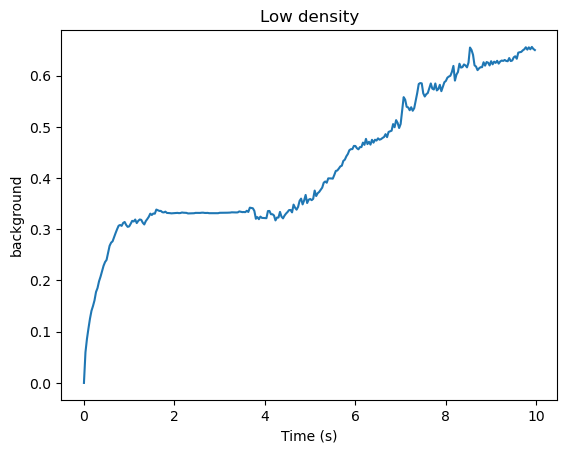

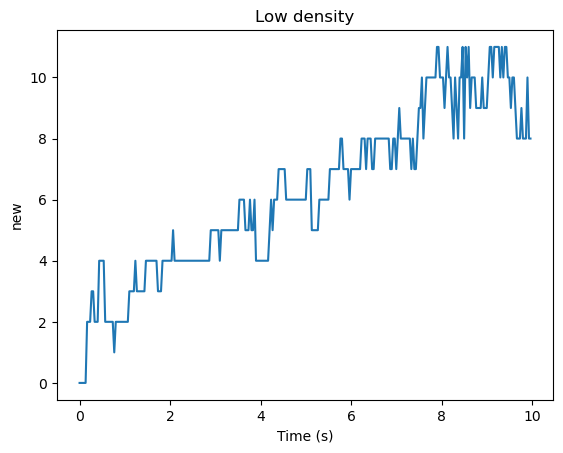

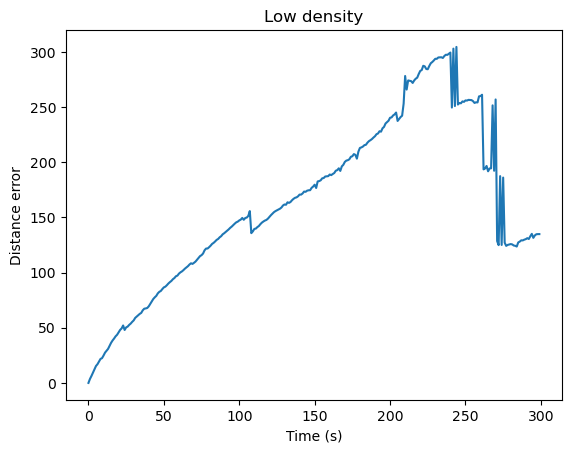

In [57]:
from corr_study.truthsetter import *
import pandas as pd
import seaborn as sns
time = 300
fp = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3low/ClearSunset/BBOX.hdf5"
dicts = find_truth(fp, 1000, time, dataset, "t3low",  Weather.Clear, Time.Sunset, Sensor.LT)
df_low = pd.DataFrame.from_dict(dicts)
df_low["Time (s)"] = np.arange(time)/30

others_low = list(df_low.columns)
others_low.remove("new")
others_low.remove("background")
others_low.remove("Time (s)")
others_low.remove("mobile")
print(others_low)
sns.lineplot(data=df_low, x="Time (s)", y="background", legend=False)
plt.title("Low density")
plt.show()
sns.lineplot(data=df_low, x="Time (s)", y="new", legend=False)
plt.title("Low density")
plt.show()
sns.lineplot(data=df_low[others_low].sum(axis=1), legend=False)
plt.xlabel("Time (s)")
plt.ylabel("Distance error")
plt.title("Low density")
plt.show()

[109, 120, 164, 213, 225, 226, 256, 285, 300, 304, 310, 341, 342, 368, 375, 393, 395, 414, 425, 446, 474, 481, 483, 523, 537, 542, 553, 568, 569, 571, 576, 579, 598, 632, 638, 674]


/tmp/ipykernel_20481/1228358799.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df, x="Time (s)", y="background", legend=False, palette=["r"])
/tmp/ipykernel_20481/1228358799.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_low, x="Time (s)", y="background", legend=False, palette=['g'])


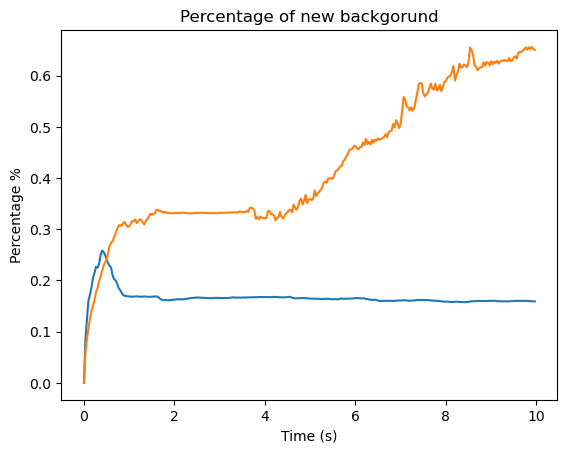

/tmp/ipykernel_20481/1228358799.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df, x="Time (s)", y="new", legend=False, palette=["r"])
/tmp/ipykernel_20481/1228358799.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_low, x="Time (s)", y="new", legend=False, palette=['g'])


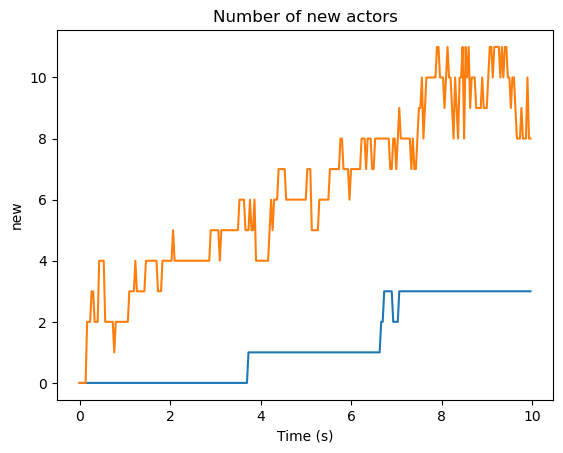

/tmp/ipykernel_20481/1228358799.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df[others].sum(axis=1), legend=False, palette=["r"])
/tmp/ipykernel_20481/1228358799.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_low[others_low].sum(axis=1), legend=False, palette=['g'])


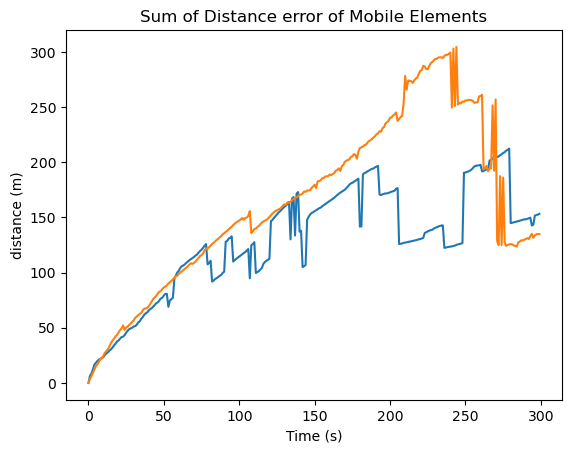

In [60]:
time = 300
fp = "/home/filo/thesis/pqos-correlation/corr_study/dataset/TLC_web/archives/t3high/ClearSunset/BBOX.hdf5"
dicts = find_truth(fp, 4413, time, dataset, "t3high",  Weather.Clear, Time.Sunset, Sensor.LT)
df = pd.DataFrame.from_dict(dicts)
df["Time (s)"] = np.arange(time)/30
others = list(df.columns)
others.remove("new")
others.remove("background")
others.remove("Time (s)")
others.remove("mobile")
print(others)
sns.lineplot(data=df, x="Time (s)", y="background", legend=False, color='r')
sns.lineplot(data=df_low, x="Time (s)", y="background", legend=False, color='g')
plt.ylabel("Percentage %")
plt.title("Percentage of new backgorund")
plt.show()
sns.lineplot(data=df, x="Time (s)", y="new", legend=False, color='r')
sns.lineplot(data=df_low, x="Time (s)", y="new", legend=False, color='g')
plt.title("Number of new actors")
plt.show()
sns.lineplot(data=df[others].sum(axis=1), legend=False, color='r')
sns.lineplot(data=df_low[others_low].sum(axis=1), legend=False, color='g')
plt.xlabel("Time (s)")
plt.ylabel("distance (m)")
plt.title("Sum of Distance error of Mobile Elements")
plt.show()

100%|██████████| 299/299 [05:22<00:00,  1.08s/it]


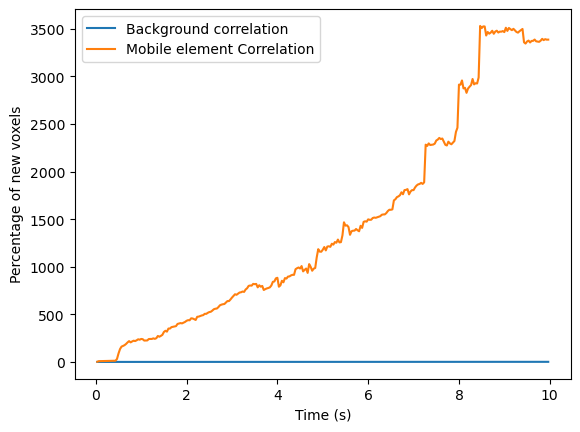

In [82]:
from tqdm import trange
m = tf.keras.models.load_model('network_miniUNet.h5')
pcd_top = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, 1)
back_correlation_low = []
mobile_correlation_low = []
previous_transformation = None
previous_centroids = None
for i in trange(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, i)
    background, mobile, previous_transformation, previous_centroids = pcd_top.compare_using_classifier(pcd_top_compare,
                                                                                                       m, 
                                                                                                       initial_transformation=previous_transformation,
                                                                                                       initial_centroids=previous_centroids)
    back_correlation_low.append(background)
    mobile_correlation_low.append(mobile)
fig, ax = plt.subplots(1,1)
bl, = ax.plot(np.arange(1,300)/30, back_correlation_low)
ml, = ax.plot(np.arange(1,300)/30, mobile_correlation_low)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Percentage of new voxels")
ax.legend([bl, ml],["Background correlation", "Mobile element Correlation"])

100%|██████████| 299/299 [05:42<00:00,  1.15s/it]


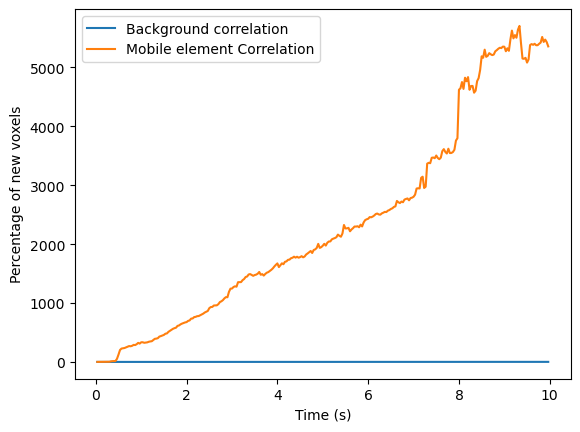

In [83]:
m = tf.keras.models.load_model('network_miniUNet.h5')
pcd_top = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, 1)
back_correlation_high = []
mobile_correlation_high = []
previous_transformation = None
previous_centroids = None
for i in trange(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, i)
    background, mobile, previous_transformation, previous_centroids = pcd_top.compare_using_classifier(pcd_top_compare,
                                                                                   m, 
                                                                                   initial_transformation=previous_transformation,
                                                                                   initial_centroids=previous_centroids)
    back_correlation_high.append(background)
    mobile_correlation_high.append(mobile)
fig, ax = plt.subplots(1,1)
bh, = ax.plot(np.arange(1,300)/30, back_correlation_high)
mh, = ax.plot(np.arange(1,300)/30, mobile_correlation_high)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Percentage of new voxels")
ax.legend([bh, mh],["Background correlation", "Mobile element Correlation"])

Text(0, 0.5, 'Distance of mobile objects')

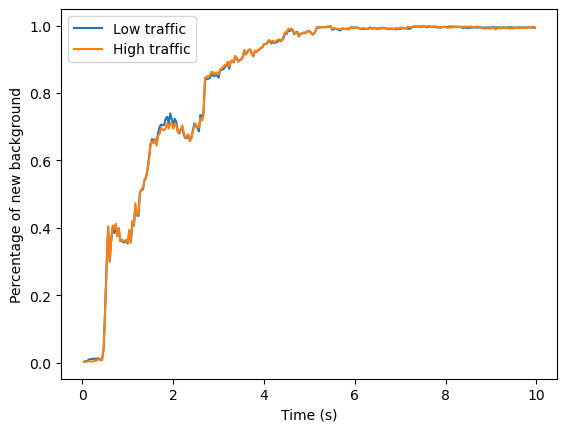

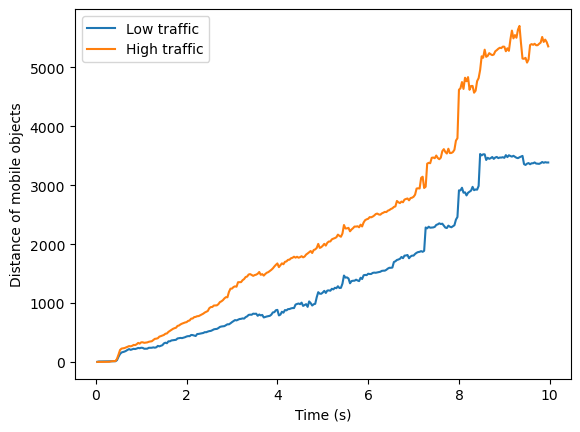

In [84]:
fig, ax = plt.subplots(1,1)
bl, = ax.plot(np.arange(1,300)/30, back_correlation_low)
bh, = ax.plot(np.arange(1,300)/30, back_correlation_high)
ax.set_ylabel("Percentage of new background")
ax.set_xlabel("Time (s)")
ax.legend([bl, bh],["Low traffic", "High traffic"])
fig, ax = plt.subplots(1,1)
ml, = ax.plot(np.arange(1,300)/30, mobile_correlation_low)
mh, = ax.plot(np.arange(1,300)/30, mobile_correlation_high)
ax.legend([ml, mh],["Low traffic", "High traffic"])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Distance of mobile objects")

In [14]:
pcd_top = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, 1)
pcd_top_2 = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, 2)
a, b = pcd_top.pippo(pcd_top_2, m)

In [15]:
source_temp = o3d.geometry.PointCloud()
source_temp.points = o3d.utility.Vector3dVector(a)
source_temp.paint_uniform_color([1, 0, 0])
target_temp = o3d.geometry.PointCloud()
target_temp.points = o3d.utility.Vector3dVector(b)
target_temp.paint_uniform_color([0, 0, 1])
o3d.visualization.draw_geometries([source_temp, target_temp])

In [18]:
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        source_temp.cluster_dbscan(eps=.5, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
source_temp.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([source_temp])

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
Precompute neighbors.[========[Open3D DEBUG] Done Compute Clusters: 25
Precompute neighbors.[========================================] 100%
point cloud has 25 clusters======================> ] 95%


KeyboardInterrupt: 

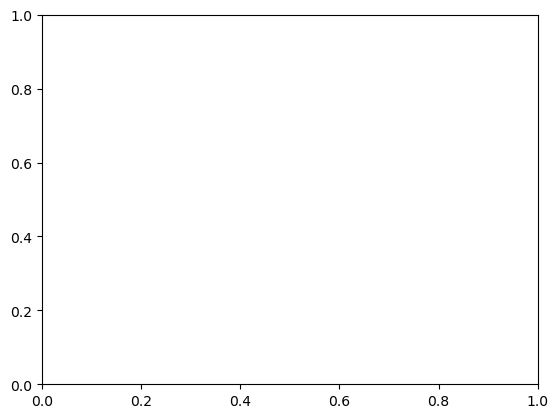

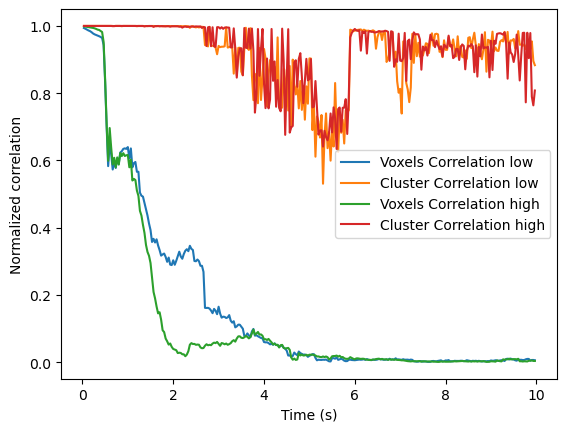

In [90]:
pcd_top = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, 1)
icp_correlation_low = []
previous_transformation = None
for i in range(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, i)
    correla, previous_transformation = pcd_top.compare_using_voxels(pcd_top_compare, 0.25, mode=selmaPointCloud.ICP_REGISTRATION, crop_street=True, init_transform=previous_transformation)
    icp_correlation_low.append(correla)
icp_cluster_correlation_low = []
previous_transformation = None
for i in range(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3low", Weather.Clear, Time.Sunset, Sensor.LT, i)
    correla, previous_transformation = pcd_top.compare_using_clusters(pcd_top_compare, 50, mode=selmaPointCloud.ICP_REGISTRATION, crop_street=True, init_transform=previous_transformation)
    icp_cluster_correlation_low.append(correla)
pcd_top = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, 1)
icp_correlation = []
previous_transformation = None
for i in range(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, i)
    correla, previous_transformation = pcd_top.compare_using_voxels(pcd_top_compare, 0.25, mode=selmaPointCloud.ICP_REGISTRATION, crop_street=True, init_transform=previous_transformation)
    icp_correlation.append(correla)
icp_cluster_correlation = []
previous_transformation = None
for i in range(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, i)
    correla, previous_transformation = pcd_top.compare_using_clusters(pcd_top_compare, 50, mode=selmaPointCloud.ICP_REGISTRATION, crop_street=True, init_transform=previous_transformation)
    icp_cluster_correlation.append(correla)
fig, ax = plt.subplots(1,1)
ppl, = ax.plot(np.arange(1,300)/30, icp_correlation_low)
pcl, = ax.plot(np.arange(1,300)/30, icp_cluster_correlation_low)
pp, = ax.plot(np.arange(1,300)/30, icp_correlation)
pc, = ax.plot(np.arange(1,300)/30, icp_cluster_correlation)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Normalized correlation")
ax.legend([ppl, pcl, pp, pc],["Voxels Correlation low", "Cluster Correlation low", "Voxels Correlation high", "Cluster Correlation high"])
plt.show()

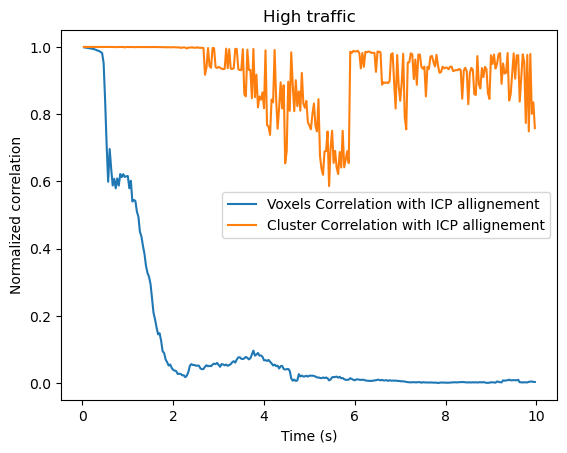

In [89]:
pcd_top = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, 1)
icp_correlation = []
previous_transformation = None
for i in range(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, i)
    correla, previous_transformation = pcd_top.compare_using_voxels(pcd_top_compare, 0.25, mode=selmaPointCloud.ICP_REGISTRATION, crop_street=True, init_transform=previous_transformation)
    icp_correlation.append(correla)
icp_cluster_correlation = []
previous_transformation = None
for i in range(2, 301):
    pcd_top_compare = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, i)
    correla, previous_transformation = pcd_top.compare_using_clusters(pcd_top_compare, 50, mode=selmaPointCloud.ICP_REGISTRATION, crop_street=True, init_transform=previous_transformation)
    icp_cluster_correlation.append(correla)
fig, ax = plt.subplots(1,1)
pp, = ax.plot(np.arange(1,300)/30, icp_correlation)
pc, = ax.plot(np.arange(1,300)/30, icp_cluster_correlation)
ax.set_title("High traffic")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Normalized correlation")
ax.legend([pp, pc],["Voxels Correlation with ICP allignement", "Cluster Correlation with ICP allignement"])
plt.show()

In [4]:
import open3d as o3d
from matplotlib import pyplot as plt
pcd_top = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, 1)
dd = pcd_top.data
# dd = dd[pcd_top.ground_truth[:,1] != 0]
dd = dd[dd[:,2]>-0.9]
dd[:,2] = 0

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(dd)


with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        pcd.cluster_dbscan(eps=2, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd])



[0. 0. 0. ... 0. 0. 0.]
[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 63
Precompute neighbors.[========================================] 100%
point cloud has 63 clusters=======================>] 97%[=======>                                ] 17%


In [64]:
pcd_top = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, 1)
pcd_top.classify_mobile(m)
pcd_top.visualize(inferred=True)

In [47]:
from scipy.ndimage import label, generate_binary_structure
structure = generate_binary_structure(2,3)
print(structure)
labels, num_labels = label(pred, structure)
print(num_labels)
plt.imsave("test.png",labels, cmap="jet")

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
118


In [72]:
pcd_top = dataset.open_measurement_sample_TLC("t3high", Weather.Clear, Time.Sunset, Sensor.LT, 1)
pcd_top.classify_mobile(m)
pcd_top._compute_cluster_centroids(visualize=True)

[4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 33, 34, 36, 37, 38, 39, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 87, 89, 90, 92, 93, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 113, 114, 115, 116, 117]
4
5
6
7
9
10
11
12
14
15
17
18
19
20
21
22
23
24
26
27
28
29
31
33
34
36
37
38
39
42
45
46
47
48
49
50
51
52
53
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
83
84
85
87
89
90
92
93
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
113
114
115
116
117


In [79]:
import numpy as np
from scipy.spatial.distance import cdist

# Generate two sets of points with 2 dimensions
points1 = np.random.rand(10, 3)
points2 = np.random.rand(8, 3)

# Compute the pairwise distances between the two sets of points
distances = cdist(points1, points2)

# Find the index of the closest point in the second set for each point in the first set
closest_indices = np.argmin(distances, axis=1)
print(points1)
print(points2)
# Print the result
print(points2[closest_indices, :])

[[0.26985757 0.91286969 0.38744598]
 [0.92258794 0.73101866 0.34774384]
 [0.37953888 0.42548351 0.95265731]
 [0.99336486 0.7470001  0.46737991]
 [0.55962559 0.31574119 0.49038495]
 [0.93049248 0.11398472 0.63143513]
 [0.33193856 0.71865239 0.80023131]
 [0.82955039 0.93332436 0.43116512]
 [0.03960089 0.95663622 0.85775454]
 [0.56874352 0.16633122 0.33362273]]
[[0.05057825 0.36950429 0.26999766]
 [0.81110081 0.73593253 0.33383174]
 [0.75004303 0.69306757 0.21869915]
 [0.72078151 0.88912919 0.28040982]
 [0.61231273 0.25119903 0.20243682]
 [0.97277553 0.14109204 0.13108616]
 [0.22738254 0.96598896 0.70443711]
 [0.08457195 0.08895164 0.76102503]]
[[0.22738254 0.96598896 0.70443711]
 [0.81110081 0.73593253 0.33383174]
 [0.08457195 0.08895164 0.76102503]
 [0.81110081 0.73593253 0.33383174]
 [0.61231273 0.25119903 0.20243682]
 [0.97277553 0.14109204 0.13108616]
 [0.22738254 0.96598896 0.70443711]
 [0.72078151 0.88912919 0.28040982]
 [0.22738254 0.96598896 0.70443711]
 [0.61231273 0.25119903 0.